In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import scipy.io as io
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.pylab as pylab
import numpy as np
from matplotlib import gridspec
import seaborn as sns
import datetime
from datetime import datetime, timedelta
import pickle
import itertools
import glob
import os
import six
import sys

In [3]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

In [4]:
import matplotlib.dates as dates
from scipy import stats
from scipy.stats import variation
from scipy.stats import skewnorm
import math
from scipy.signal import butter, filtfilt
import itertools

In [5]:
import matplotlib.pyplot as plt
#font = {'family': 'serif', 'serif': ['Palatino']}
font = {'family': 'serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [6]:
label_fontsize = 16
title_fontsize = 16

In [7]:
#Set up parameters for figure display
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'axes.labelweight': 'bold',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
pylab.rcParams["font.family"] = "serif"
pylab.rcParams["font.weight"] = "heavy"
#pylab.rcParams.update({'figure.autolayout': True})

In [8]:
sns.set(font_scale=1.25, style="whitegrid")

In [9]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
# for ignoring scipy RuntimeWarning: invalid value encountered in double_scalars

In [10]:
import multiprocessing
from multiprocessing import Pool

In [11]:
multiprocessing.cpu_count()

12

In [12]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [13]:
base_dir = '/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/'
beh_files = 'decAlertnessDecisionmaking_JNeuroscience2021/beh_data/csv_files/'
output_dir = 'decAlertnessDecisionmaking_JNeuroscience2021/Figures/'

In [14]:
import hddm
print (hddm.__version__)

0.8.0


/home/srj34/hddm-env3/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [15]:
def interpolate_trace(x, trace, range=(-1,1), bins=100):
    """Interpolate distribution (from samples) at position x.
    :Arguments:
        x <float>: position at which to evalute posterior.
        trace <np.ndarray>: Trace containing samples from posterior.
    :Optional:
        range <tuple=(-1,1): Bounds of histogram (should be fairly
            close around region of interest).
        bins <int=100>: Bins of histogram (should depend on trace length).
    :Returns:
        float: Posterior density at x.
    """

    import scipy.interpolate

    x_histo = np.linspace(range[0], range[1], bins)
    histo = np.histogram(trace, bins=bins, range=range, density=True)[0]
    interp = scipy.interpolate.InterpolatedUnivariateSpline(x_histo, histo)(x)

    return interp

In [16]:
def savePatch(self, fname):
    with open(fname, 'wb') as f:
        pickle.dump(self, f)
hddm.HDDM.savePatch = savePatch

In [17]:
def effectsize(group1_node, group2_node):
    import pymc3 as pm
    with pm.Model() as model:
        group1 = group1_node.trace()
        group2 = group2_node.trace()
        group1_mean = group1.mean()
        group2_mean = group2.mean()
        group1_std = group1.std()
        group2_std = group2.std()
        diff_of_means = group1_mean - group2_mean
        diff_of_stds = group1_std - group2_std
        effect_size = diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2)
    return effect_size

In [18]:
#read the csv file first (created by process_create_StimCodeRTs)
csvfilepath = base_dir + beh_files + "responsecoding_stimcode_state.csv"

In [19]:
data_overall = hddm.load_csv(csvfilepath)
#data_overall['rt'] = data_overall['rt']

#now remove some of the unwanted columns to keep it clean..
del data_overall['angle']
del data_overall['accuracy']
del data_overall['stimcode']
del data_overall['difficulty']

#sorted(data_overall.angle.unique())

#now reorder them..
data_overall = data_overall[['subj_idx', 'ovtrlnums', 'stim', 'rt', 'response', 'state']]

In [20]:
data_overall.head(10)

,subj_idx,ovtrlnums,stim,rt,response,state
0,2.0,1.0,Right,0.904771,0,Alert
1,2.0,2.0,Left,1.032423,1,Alert
2,2.0,3.0,Left,1.145844,1,Alert
3,2.0,4.0,Left,1.099559,1,Alert
4,2.0,5.0,Left,1.228592,1,Alert
5,2.0,6.0,Right,1.541085,0,Alert
6,2.0,7.0,Right,0.864819,0,Alert
7,2.0,8.0,Right,0.826864,0,Alert
8,2.0,9.0,Left,0.834556,1,Alert
9,2.0,10.0,Left,0.684214,1,Alert


In [21]:
data_overall.tail(10)

,subj_idx,ovtrlnums,stim,rt,response,state
21173,46.0,846.0,Left,0.984939,1,Relaxed
21174,46.0,847.0,Left,2.327742,1,Relaxed
21175,46.0,848.0,Left,2.852602,1,Drowsy
21176,46.0,850.0,Left,1.367680,1,Relaxed
21177,46.0,851.0,Left,0.786586,1,Relaxed
21178,46.0,853.0,Left,4.871518,1,Drowsy
21179,46.0,855.0,Left,1.711324,1,Drowsy
21180,46.0,857.0,Right,1.241904,0,Relaxed
21181,46.0,863.0,Left,0.927672,1,Relaxed
21182,46.0,864.0,Right,0.547870,0,Relaxed


In [22]:
statepurgegrp = ['Relaxed'] #remove this state from the data..
data = data_overall[~data_overall['state'].isin(statepurgegrp)]

In [23]:
np.max(data.rt)

4.908807

In [24]:
np.min(data.rt)

0.024684

In [25]:
data.state.unique()

array(['Alert', 'Drowsy'], dtype=object)

In [26]:
data.subj_idx.unique()

array([ 2.,  4.,  5.,  6.,  7.,  9., 10., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       41., 42., 43., 44., 45., 46.])

In [27]:
print ('RT mean - Alert:' + str(1000*np.mean(data.rt[data.state == 'Alert'])))
print ('RT mean - Drowsy:' + str(1000*np.mean(data.rt[data.state == 'Drowsy'])))

RT mean - Alert:695.152978332419
RT mean - Drowsy:1207.8168836779107


In [28]:
model_basedir = base_dir + 'decAlertnessDecisionmaking_JNeuroscience2021/beh_data/hddm_models'

In [29]:
fig_dir = base_dir + output_dir
fig_dir

'/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Figures/'

In [30]:
import pymc
pymc.__version__

'2.3.8'

In [31]:
num_samples = 1500 #10

In [32]:
#model variations are done based on..
#https://github.com/anne-urai/2019_Urai_choice-history-ddm/blob/master/hddm_models.py

In [33]:
#evaluate models with only drift-rate and bias-point..
#in this model set, drift_criterion=False, bias=True, however vary them by specific conditions..

In [34]:
def multi_run_v_z_hddm(args):
    tempargs = args
    
    v_pars = tempargs[0]
    z_pars = tempargs[1]
    tempval = tempargs[2]
    model_name = tempargs[3]
    model_dir = tempargs[4]
    
    model_fullname = os.path.join(model_dir, model_name+ '_db')
    
    
    print('\n##### model '+ str(tempval) + ' #####')
    print('\nmodel location:',model_fullname)


    if not os.path.exists(model_fullname):

        m = hddm.HDDMStimCoding(data, p_outlier = 0.05, stim_col='stim', split_param='v',
                                drift_criterion=False, bias=True,
                                depends_on={'v':v_pars, 'z':z_pars})
        m.find_starting_values()    
        samples = num_samples
        num_burn = num_samples/10
        tracefilename = 'traces_' + str(tempval) + '.db' #'traces.db'
        if not os.path.exists(model_dir):
               os.makedirs(model_dir)
        m.sample(samples, burn=num_burn, thin=3, dbname=os.path.join(model_dir, tracefilename), 
                 db='pickle')
        m.savePatch(model_fullname)
    else:
        print('\nmodelfile: ' + model_fullname + ' \n already exists..')
        if os.path.isfile(model_fullname):
            with open(model_fullname, 'rb') as f:
                    m_load = pickle.load(f)
        m = m_load 
    
    return  m

In [35]:
#first evaluate all models and then choose the best among them..
params_v = [{'state'},{'stim'},{'state','stim'}]
params_z = [{'state'},{'stim'},{'state','stim'}]

totalparams = range(0, len(params_v))
tempval = 1

v_list = []
z_list = []
tempval_list=[]
modelname_list = []
modeldir_list = []

for p in range(len(totalparams)):
    for q in range(len(totalparams)):
        
        v_len = len(params_v[p])
        z_len = len(params_z[q])

        v_pars = params_v[p]
        z_pars = params_z[q]


        tot_len = v_len + z_len

        if tot_len >=4: #to skip complex params with both varying..
            continue

        model_name = 'model_'+ str(tempval)
        model_dir = model_basedir +'/vdrift_zbias_models' +'/' + model_name
        model_fullname = os.path.join(model_dir, model_name+ '_db')
        
        v_list.append(v_pars)
        z_list.append(z_pars)
        modelname_list.append(model_name)
        modeldir_list.append(model_dir)
        tempval_list.append(tempval)
        tempval = tempval + 1

In [36]:
fullist = [x for x in zip(v_list, z_list,tempval_list,modelname_list,modeldir_list)]

In [37]:
#takes 30 mins to run the 8 different models..

In [38]:
if __name__ == "__main__":
    with HiddenPrints(): #the multiprocessing prints are just not ordered..
        pool = Pool(multiprocessing.cpu_count()) 
        result = pool.map(multi_run_v_z_hddm,fullist)

In [39]:
v_z_model = []

In [40]:
for v_paridx, z_paridx, tempval_paridx, modelname_paridx,modeldir_paridx, in fullist:
    m_paridx = result[int(tempval_paridx)-1]
    m_stats = m_paridx.gen_stats()
    print('\n##### model '+ str(int(tempval_paridx)) + ' #####')
    print('model parms','v:', ', '.join(v_paridx),'z:', ', '.join(z_paridx))
    print(modelname_paridx, 'DIC {0:.2f}'.format(m_paridx.dic))
    v_z_model.append([int(tempval_paridx)-1, ', '.join(v_paridx), ', '.join(z_paridx),
                           '{0:.2f}'.format(m_paridx.dic)])


##### model 1 #####
model parms v: state z: state
model_1 DIC 22710.09

##### model 2 #####
model parms v: state z: stim
model_2 DIC 22679.67

##### model 3 #####
model parms v: state z: stim, state
model_3 DIC 22477.21

##### model 4 #####
model parms v: stim z: state
model_4 DIC 24295.95

##### model 5 #####
model parms v: stim z: stim
model_5 DIC 24144.91

##### model 6 #####
model parms v: stim z: stim, state
model_6 DIC 22333.18

##### model 7 #####
model parms v: stim, state z: state
model_7 DIC 21918.07

##### model 8 #####
model parms v: stim, state z: stim
model_8 DIC 21912.64


In [41]:
#evaluate models with only drift-rate and drift criterion..
#in this model set, drift_criterion=True, bias=False, however vary them by specific conditions..

In [42]:
def multi_run_v_dc_hddm(args):
    tempargs = args
    
    v_pars = tempargs[0]
    dc_pars = tempargs[1]
    tempval = tempargs[2]
    model_name = tempargs[3]
    model_dir = tempargs[4]
    
    model_fullname = os.path.join(model_dir, model_name+ '_db')
    
    
    print('\n##### model '+ str(tempval) + ' #####')
    print('\nmodel location:',model_fullname)


    if not os.path.exists(model_fullname):

        m = hddm.HDDMStimCoding(data, p_outlier = 0.05, stim_col='stim', split_param='v',
                                    drift_criterion=True, bias=False,
                                    depends_on={'v':v_pars, 'dc': dc_pars})
        m.find_starting_values()    
        samples = num_samples
        num_burn = num_samples/10
        tracefilename = 'traces_' + str(tempval) + '.db' #'traces.db'
        if not os.path.exists(model_dir):
               os.makedirs(model_dir)
        m.sample(samples, burn=num_burn, thin=3, dbname=os.path.join(model_dir, tracefilename), 
                 db='pickle')
        m.savePatch(model_fullname)
    else:
        print('\nmodelfile: ' + model_fullname + ' \n already exists..')
        if os.path.isfile(model_fullname):
            with open(model_fullname, 'rb') as f:
                    m_load = pickle.load(f)
        m = m_load 
    
    return  m

In [43]:
#first evaluate all models and then choose the best among them..
params_v = [{'state'},{'stim'},{'state','stim'}]
params_dc = [{'state'},{'stim'},{'state','stim'}]

totalparams = range(0, len(params_v))
tempval = 1

v_list = []
dc_list = []
tempval_list=[]
modelname_list = []
modeldir_list = []

for p in range(len(totalparams)):
    for q in range(len(totalparams)):
        
        v_len = len(params_v[p])
        dc_len = len(params_dc[q])

        v_pars = params_v[p]
        dc_pars = params_dc[q]

        tot_len = v_len + dc_len

        if tot_len >=4: #to skip complex params with both varying..
            continue

        model_name = 'model_'+ str(tempval)

        model_dir = model_basedir +'/vdrift_dcbias_models' +'/' + model_name
        model_fullname = os.path.join(model_dir, model_name+ '_db')
        
        v_list.append(v_pars)
        dc_list.append(dc_pars)
        modelname_list.append(model_name)
        modeldir_list.append(model_dir)
        tempval_list.append(tempval)
        tempval = tempval+1 

In [44]:
fullist = [x for x in zip(v_list, dc_list,tempval_list,modelname_list,modeldir_list)]

In [45]:
#takes 30 mins to run the 8 different models..

In [46]:
if __name__ == "__main__":
    with HiddenPrints(): #the multiprocessing prints are just not ordered..
        pool = Pool(multiprocessing.cpu_count()) 
        result = pool.map(multi_run_v_dc_hddm,fullist)

In [47]:
v_dc_model = []

In [48]:
for v_paridx, dc_paridx, tempval_paridx, modelname_paridx,modeldir_paridx, in fullist:
    m_paridx = result[int(tempval_paridx)-1]
    m_stats = m_paridx.gen_stats()
    print('\n##### model '+ str(int(tempval_paridx)) + ' #####')
    print('model parms','v:', ', '.join(v_paridx),'dc:', ', '.join(dc_paridx))
    print(modelname_paridx, 'DIC {0:.2f}'.format(m_paridx.dic))
    v_dc_model.append([int(tempval_paridx), ', '.join(v_paridx), ', '.join(dc_paridx),
                           '{0:.2f}'.format(m_paridx.dic)])


##### model 1 #####
model parms v: state dc: state
model_1 DIC 22039.18

##### model 2 #####
model parms v: state dc: stim
model_2 DIC 22077.18

##### model 3 #####
model parms v: state dc: stim, state
model_3 DIC 22038.09

##### model 4 #####
model parms v: stim dc: state
model_4 DIC 24339.96

##### model 5 #####
model parms v: stim dc: stim
model_5 DIC 24400.85

##### model 6 #####
model parms v: stim dc: stim, state
model_6 DIC 22044.68

##### model 7 #####
model parms v: stim, state dc: state
model_7 DIC 22043.29

##### model 8 #####
model parms v: stim, state dc: stim
model_8 DIC 22045.73


In [49]:
v_z_model_df = pd.DataFrame(v_z_model, columns=['Model', 'drift-rate (v)', 'bias-point (z)','DIC score'])
v_z_model_df['type'] = 'drift, bias'
v_z_model_df.sort_values('DIC score')

,Model,drift-rate (v),bias-point (z),DIC score,type
7,7,"stim, state",stim,21912.64,"drift, bias"
6,6,"stim, state",state,21918.07,"drift, bias"
5,5,stim,"stim, state",22333.18,"drift, bias"
2,2,state,"stim, state",22477.21,"drift, bias"
1,1,state,stim,22679.67,"drift, bias"
0,0,state,state,22710.09,"drift, bias"
4,4,stim,stim,24144.91,"drift, bias"
3,3,stim,state,24295.95,"drift, bias"


In [50]:
v_dc_model_df = pd.DataFrame(v_dc_model, columns=['Model', 'drift-rate (v)', 'drift-criterion (dc)','DIC score'])
v_dc_model_df['type'] = 'drift, dc'
v_dc_model_df.sort_values('DIC score')

,Model,drift-rate (v),drift-criterion (dc),DIC score,type
2,3,state,"stim, state",22038.09,"drift, dc"
0,1,state,state,22039.18,"drift, dc"
6,7,"stim, state",state,22043.29,"drift, dc"
5,6,stim,"stim, state",22044.68,"drift, dc"
7,8,"stim, state",stim,22045.73,"drift, dc"
1,2,state,stim,22077.18,"drift, dc"
3,4,stim,state,24339.96,"drift, dc"
4,5,stim,stim,24400.85,"drift, dc"


In [51]:
#so the best model, so far is based on drift-rate and bias-point..
#let's add few more details to that..

In [52]:
def multi_run_v_z_a_t_hddm(args):
    tempargs = args
    
    v_pars = tempargs[0]
    z_pars = tempargs[1]
    a_pars = tempargs[2]
    t_pars = tempargs[3]
    tempval = tempargs[4]
    model_name = tempargs[5]
    model_dir = tempargs[6]
    
    model_fullname = os.path.join(model_dir, model_name+ '_db')
    
    
    print('\n##### model '+ str(tempval) + ' #####')
    print('\nmodel location:',model_fullname)


    if not os.path.exists(model_fullname):

        m = hddm.HDDMStimCoding(data, p_outlier = 0.05, stim_col='stim', split_param='v',
                                drift_criterion=False, bias=True,
                                depends_on={'v':v_pars, 'z':z_pars, 'a':a_pars, 't': t_pars})   
        m.find_starting_values()    
        samples = num_samples
        num_burn = num_samples/10
        tracefilename = 'traces_' + str(tempval) + '.db' #'traces.db'
        if not os.path.exists(model_dir):
               os.makedirs(model_dir)
        m.sample(samples, burn=num_burn, thin=3, dbname=os.path.join(model_dir, tracefilename), 
                 db='pickle')
        m.savePatch(model_fullname)
    else:
        print('\nmodelfile: ' + model_fullname + ' \n already exists..')
        if os.path.isfile(model_fullname):
            with open(model_fullname, 'rb') as f:
                    m_load = pickle.load(f)
        m = m_load 
    
    return  m

In [53]:
#first evaluate all models and then choose the best among them..
params_v = [{'state','stim'}]# best fits from previous model..
params_z = [{'stim'}]# best fits from previous model..
params_a = [{'state'},{'stim'}]
params_t = [{'state'},{'stim'}]

totalparams = range(0, len(params_t))
tempval = 1

v_list = []
z_list = []
a_list = []
t_list = []
tempval_list=[]
modelname_list = []
modeldir_list = []

for p in range(len(totalparams)):
    for q in range(len(totalparams)):
        
        v_pars = params_v[0]
        z_pars = params_z[0]
        a_pars = params_a[p]
        t_pars = params_t[q]


        model_name = 'model_'+ str(tempval)

        model_dir = model_basedir +'/combined_models' +'/' + model_name
        model_fullname = os.path.join(model_dir, model_name+ '_db')
        
        v_list.append(v_pars)
        z_list.append(z_pars)
        a_list.append(a_pars)
        t_list.append(t_pars)
        modelname_list.append(model_name)
        modeldir_list.append(model_dir)
        tempval_list.append(tempval)
        tempval = tempval+1     

In [54]:
fullist = [x for x in zip(v_list, z_list, a_list, t_list, tempval_list,modelname_list,modeldir_list)]

In [55]:
#takes 30 mins to run the 4 different models..

In [56]:
if __name__ == "__main__":
    with HiddenPrints(): #the multiprocessing prints are just not ordered..
        pool = Pool(multiprocessing.cpu_count()) 
        result = pool.map(multi_run_v_z_a_t_hddm,fullist)

In [57]:
v_z_a_t_model = []

In [58]:
v_list = []
z_list = []
a_list = []
t_list = []

In [59]:
for v_paridx, z_paridx, a_paridx, t_paridx, tempval_paridx, modelname_paridx,modeldir_paridx, in fullist:
    m_paridx = result[int(tempval_paridx)-1]
    m_stats = m_paridx.gen_stats()
    print('\n##### model '+ str(int(tempval_paridx)) + ' #####')
    print('model parms','v:', ', '.join(v_paridx),'z:', ', '.join(z_paridx),
                        'a:', ', '.join(a_paridx),'t:', ', '.join(t_paridx))
    print(modelname_paridx, 'DIC {0:.2f}'.format(m_paridx.dic))
    v_z_a_t_model.append([int(tempval_paridx), ', '.join(v_paridx), ', '.join(z_paridx),
                          ', '.join(a_paridx), ', '.join(t_paridx),
                          '{0:.2f}'.format(m_paridx.dic)])


##### model 1 #####
model parms v: stim, state z: stim a: state t: state
model_1 DIC 20333.06

##### model 2 #####
model parms v: stim, state z: stim a: state t: stim
model_2 DIC 20690.26

##### model 3 #####
model parms v: stim, state z: stim a: stim t: state
model_3 DIC 20922.25

##### model 4 #####
model parms v: stim, state z: stim a: stim t: stim
model_4 DIC 21690.95


In [60]:
v_z_a_t_model_df = pd.DataFrame(v_z_a_t_model, columns=['Model', 'drift-rate (v)', 'bias-point (z)',
                                                        'boundary (a)', 'non-decision time (t)','DIC score'])
v_z_a_t_model_df['type'] = 'combined'
v_z_a_t_model_df.sort_values('DIC score')

,Model,drift-rate (v),bias-point (z),boundary (a),non-decision time (t),DIC score,type
0,1,"stim, state",stim,state,state,20333.06,combined
1,2,"stim, state",stim,state,stim,20690.26,combined
2,3,"stim, state",stim,stim,state,20922.25,combined
3,4,"stim, state",stim,stim,stim,21690.95,combined


In [61]:
allmodel_df = pd.concat([v_z_model_df,v_dc_model_df,v_z_a_t_model_df], sort=False)
allmodel_df = allmodel_df[['Model', 'drift-rate (v)', 'bias-point (z)', 'drift-criterion (dc)',
                           'boundary (a)','non-decision time (t)', 'DIC score', 'type']]
allmodel_df = allmodel_df.reset_index(drop=True)
# allmodel_df.Model = allmodel_df.index + 1
allmodel_df = allmodel_df.replace(np.nan,'-')
allmodel_df['DIC score'] = pd.to_numeric(allmodel_df['DIC score'])
allmodel_df.sort_values('DIC score')

,Model,drift-rate (v),bias-point (z),drift-criterion (dc),boundary (a),non-decision time (t),DIC score,type
16,1,"stim, state",stim,-,state,state,20333.06,combined
17,2,"stim, state",stim,-,state,stim,20690.26,combined
18,3,"stim, state",stim,-,stim,state,20922.25,combined
19,4,"stim, state",stim,-,stim,stim,21690.95,combined
7,7,"stim, state",stim,-,-,-,21912.64,"drift, bias"
6,6,"stim, state",state,-,-,-,21918.07,"drift, bias"
10,3,state,-,"stim, state",-,-,22038.09,"drift, dc"
8,1,state,-,state,-,-,22039.18,"drift, dc"
14,7,"stim, state",-,state,-,-,22043.29,"drift, dc"
13,6,stim,-,"stim, state",-,-,22044.68,"drift, dc"


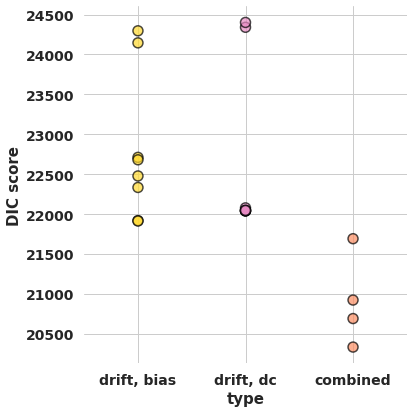

In [62]:
f, ax1 = plt.subplots(nrows =1, ncols=1, figsize=(6, 6))

sns.stripplot(x="type", y="DIC score", data=allmodel_df,jitter=False, linewidth=1.5, ax=ax1, size = 10,
              edgecolor ="black", alpha = 0.7, palette = 'Set2_r')

ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

plt.tight_layout()
plt.box(False)
plt.grid(True)
plt.savefig(fig_dir + "model_comparison_dic.png", bbox_inches = 'tight', pad_inches = 0.1)

In [63]:
#So, the best model is 'v:'-> ('state', 'stim'), 'z:' ->('stim'), 't:' ->('state'), 'a:' ->('state')

In [64]:
model_name = 'model_1'          
v_pars = {'state','stim'}
z_pars = {'stim'}
a_pars = {'state'}
t_pars = {'state'}
model_dir = model_basedir +'/combined_models/' + model_name
model_fullname = os.path.join(model_dir, model_name+ '_db')
if os.path.isfile(model_fullname):
    with open(model_fullname, 'rb') as f:
             m_load = pickle.load(f)
m = m_load

In [65]:
m.dic

20333.05696583114

## Now check for model convergence

In [66]:
testmodel = m

In [67]:
testmodel.print_stats()

                               mean       std      2.5q       25q       50q       75q     97.5q    mc err
a(Alert)                   1.473893  0.076499  1.325430  1.422887  1.472133  1.524870  1.626781  0.000945
a(Drowsy)                  2.007310  0.080218  1.851593  1.953908  2.005799  2.061431  2.167363  0.001038
a_std                      0.443398  0.045928  0.363918  0.410982  0.439566  0.473073  0.541401  0.000590
a_subj(Alert).2.0          1.953313  0.146682  1.703717  1.849663  1.939745  2.043349  2.277083  0.002879
a_subj(Alert).4.0          1.282127  0.083614  1.134812  1.221835  1.277820  1.337087  1.457034  0.001493
a_subj(Alert).5.0          1.460792  0.117665  1.257009  1.376077  1.454270  1.534953  1.710565  0.003248
a_subj(Alert).6.0          1.758623  0.104722  1.562929  1.686428  1.752762  1.826131  1.973420  0.001789
a_subj(Alert).7.0          1.537344  0.106807  1.347606  1.463193  1.529392  1.603818  1.768440  0.002466
a_subj(Alert).9.0          1.354658  0.092792 

In [68]:
##Check if the model is converged..
models = []
for i in range(5):
    testmodel.find_starting_values()
    testmodel.sample(15000, burn=5000)
    models.append(testmodel)

 [-----------------100%-----------------] 15001 of 15000 complete in 3528.0 sec

In [69]:
model_conv = hddm.analyze.gelman_rubin(models)

In [70]:
print('Did all models converge: ',all(listidx < 1.1 for listidx in list(model_conv.values())))

Did all models converge:  True


In [71]:
right_col = "lime"
left_col = "gold"

In [72]:
def hdi_of_mcmc( sample_vec, cred_mass = 0.95 ):
    assert len(sample_vec), 'need points to find HDI'
    sorted_pts = np.sort( sample_vec )

    ci_idx_inc = int(np.floor( cred_mass*len(sorted_pts) ))
    n_cis = len(sorted_pts) - ci_idx_inc
    ci_width = sorted_pts[ci_idx_inc:] - sorted_pts[:n_cis]

    min_idx = np.argmin(ci_width)
    hdi_min = sorted_pts[min_idx]
    hdi_max = sorted_pts[min_idx+ci_idx_inc]
    return hdi_min, hdi_max

def round_num(n):
            sig_figs = significant_fig_func(n)
            return "{n:.{sig_figs}g}".format(n=n, sig_figs=sig_figs)

In [73]:
ref_val = 0

def format_as_percent(x, round_to=0):
        return "{0:.{1:d}f}%".format(100 * x, round_to)

In [74]:
alert_col = "r"
drowsy_col = "b"

/home/srj34/hddm-env3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


P_t(t_Alert > t_Drowsy) =  19.950000000000003
Effect size =  1.0503099672696754


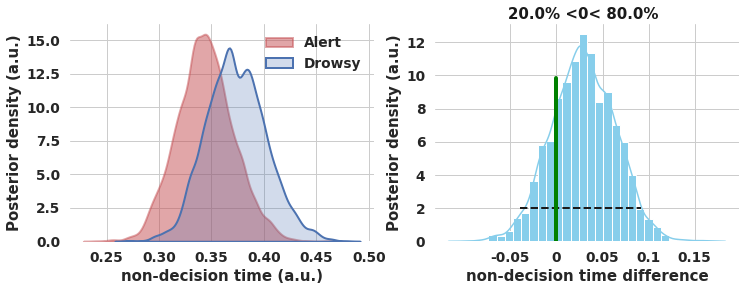

In [75]:
t_Alert, t_Drowsy = m.nodes_db.node[['t(Alert)', 't(Drowsy)']]
# Set figsize here
ax_labelsize = 12
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axplot_1 = sns.kdeplot(t_Alert.trace(), shade = True, vertical=False, label = "Alert",color = alert_col,
                       linewidth = 2, ax=ax[0])   
axplot_1.collections[0].set_alpha(0.5)
axplot_2 = sns.kdeplot(t_Drowsy.trace(), shade = True, vertical=False, label = "Drowsy", color = drowsy_col,
                       linewidth = 2,ax=ax[0])
axplot_2.collections[0].set_alpha(0.5)
axplot_3 = ax[0].legend(['Alert','Drowsy'],loc='upper right',framealpha = 0)
ax[0].set(xlabel='non-decision time (a.u.)', ylabel='Posterior density (a.u.)')

effect_size = effectsize(t_Drowsy, t_Alert)
trace = t_Drowsy.trace() - t_Alert.trace()

axplot_1 = sns.distplot(trace, bins = 30, kde=True, hist = True, vertical=False, color='#87ceeb',
                        ax=ax[1],hist_kws={"rwidth":2,'edgecolor':'white', 'alpha':1.0})

axplot_1.set_xticks(ticks = [-0.05, 0, 0.05, 0.10, 0.15, 0.20])
labels = [-0.05, 0, 0.05, 0.10, 0.15, 0.20]
axplot_1.set_xticklabels(labels)


less_than_ref_probability = (trace < ref_val).mean()
greater_than_ref_probability = (trace >= ref_val).mean()

ref_in_posterior = "{} <{:g}< {}".format(format_as_percent(less_than_ref_probability, 1),
                                                            ref_val,
                    format_as_percent(greater_than_ref_probability, 1),)

axplot_1.text(trace.mean(),1.05 * 12.75,ref_in_posterior,color="k", weight="bold",horizontalalignment="center")

hpd_intervals = hdi_of_mcmc(trace)
axplot_1.plot(hpd_intervals,(1 * 2, 1 * 2),
              lw=1 * 2, color='k', ls = '--', solid_capstyle="round",)

axplot_1.axvline(x=0, ymin=0, ymax=0.75, lw=1 * 4, color="green", ls = '-', solid_capstyle="round")

axplot_1.set(xlabel='non-decision time difference', ylabel='Posterior density (a.u.)')

axplot_1.set_frame_on(False)
axplot_1.grid(True)
axplot_2.set_frame_on(False)
axplot_2.grid(True)

print ('P_t(t_Alert > t_Drowsy) = ', 100*(t_Alert.trace() > t_Drowsy.trace()).mean())
print ('Effect size = ', effect_size)
plt.savefig(fig_dir + "non-decision_time.png", bbox_inches = 'tight', pad_inches = 0.1)

/home/srj34/hddm-env3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


P_t(t_Alert > t_Drowsy) =  0.0
Effect size =  6.9069791962997105


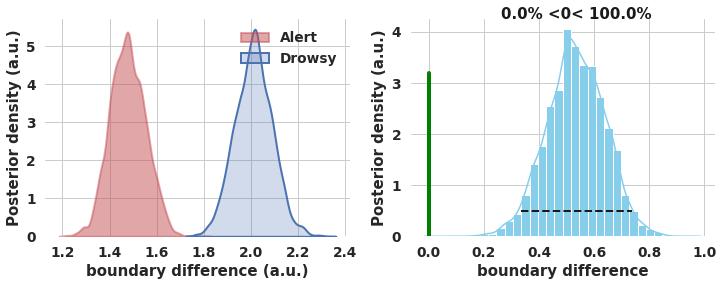

In [76]:
a_Alert, a_Drowsy = m.nodes_db.node[['a(Alert)', 'a(Drowsy)']]
# Set figsize here
ax_labelsize = 12
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axplot_1 = sns.kdeplot(a_Alert.trace(), shade = True, vertical=False, label = "Alert",color = alert_col,
                       linewidth = 2, ax=ax[0])   
axplot_1.collections[0].set_alpha(0.5)
axplot_2 = sns.kdeplot(a_Drowsy.trace(), shade = True, vertical=False, label = "Drowsy", color = drowsy_col,
                       linewidth = 2,ax=ax[0])
axplot_2.collections[0].set_alpha(0.5)
axplot_3 = ax[0].legend(['Alert','Drowsy'],loc='upper right',framealpha = 0)
ax[0].set(xlabel='boundary difference (a.u.)', ylabel='Posterior density (a.u.)')

effect_size = effectsize(a_Drowsy, a_Alert)
trace = a_Drowsy.trace() - a_Alert.trace()

axplot_1 = sns.distplot(trace, bins = 30, kde=True, hist = True, vertical=False, color='#87ceeb',
                        ax=ax[1],hist_kws={"rwidth":2,'edgecolor':'white', 'alpha':1.0})

# axplot_1.set_xticks(ticks = [-0.05, 0, 0.05, 0.10, 0.15, 0.20])
# labels = [-0.05, 0, 0.05, 0.10, 0.15, 0.20]
# axplot_1.set_xticklabels(labels)

less_than_ref_probability = (trace < ref_val).mean()
greater_than_ref_probability = (trace >= ref_val).mean()

ref_in_posterior = "{} <{:g}< {}".format(format_as_percent(less_than_ref_probability, 1),
                                                            ref_val,
                    format_as_percent(greater_than_ref_probability, 1),)

axplot_1.text(trace.mean(),1.0 * 4.25,ref_in_posterior,color="k", weight="bold",horizontalalignment="center")

hpd_intervals = hdi_of_mcmc(trace)
axplot_1.plot(hpd_intervals,(1 * 0.5, 1 * 0.5),
              lw=1 * 2, color='k', ls = '--', solid_capstyle="round",)

axplot_1.axvline(x=0, ymin=0, ymax=0.75, lw=1 * 4, color="green", ls = '-', solid_capstyle="round")

axplot_1.set(xlabel='boundary difference', ylabel='Posterior density (a.u.)')

axplot_1.set_frame_on(False)
axplot_1.grid(True)
axplot_2.set_frame_on(False)
axplot_2.grid(True)

print ('P_t(t_Alert > t_Drowsy) = ', 100*(a_Alert.trace() > a_Drowsy.trace()).mean())
print ('Effect size = ', effect_size)
plt.savefig(fig_dir + "boundary.png", bbox_inches = 'tight', pad_inches = 0.1)

/home/srj34/hddm-env3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


P_z(z_Right > z_Left) =  0.75
Effect size =  3.764594383057986


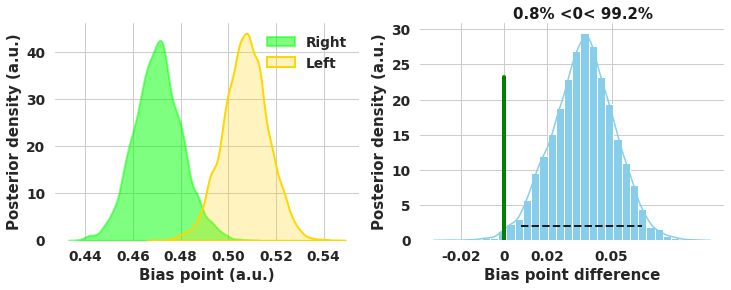

In [77]:
z_Right, z_Left = m.nodes_db.node[['z(Right)', 'z(Left)']]
# Set figsize here
ax_labelsize = 12
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axplot_1 = sns.kdeplot(z_Right.trace(), shade = True, vertical=False, label = "Right",color = right_col,
                       linewidth = 2, ax=ax[0])   
axplot_1.collections[0].set_alpha(0.5)
axplot_2 = sns.kdeplot(z_Left.trace(), shade = True, vertical=False, label = "Left", color = left_col,
                       linewidth = 2,ax=ax[0])
axplot_2.collections[0].set_alpha(0.5)
axplot_3 = ax[0].legend(['Right','Left'],loc='upper right',framealpha = 0)
ax[0].set(xlabel='Bias point (a.u.)', ylabel='Posterior density (a.u.)')
effect_size = effectsize(z_Left, z_Right)
trace = z_Left.trace() - z_Right.trace()

axplot_1 = sns.distplot(trace, bins = 30, kde=True, hist = True, vertical=False, color='#87ceeb',
                        ax=ax[1],hist_kws={"rwidth":2,'edgecolor':'white', 'alpha':1.0})

axplot_1.set_xticks(ticks = [-0.05, -0.02, 0, 0.02, 0.05])
labels = [-0.05, -0.02, 0, 0.02, 0.05]
axplot_1.set_xticklabels(labels)

less_than_ref_probability = (trace < ref_val).mean()
greater_than_ref_probability = (trace >= ref_val).mean()

ref_in_posterior = "{} <{:g}< {}".format(format_as_percent(less_than_ref_probability, 1),ref_val,
            format_as_percent(greater_than_ref_probability, 1),)

axplot_1.text(trace.mean(),2 * 15.75,ref_in_posterior,color="k", weight="bold",horizontalalignment="center")

hpd_intervals = hdi_of_mcmc(trace)
axplot_1.plot(hpd_intervals,(1 * 2, 1 * 2),
              lw=1 * 2, color='k', ls = '--', solid_capstyle="round",)

axplot_1.axvline(x=0, ymin=0, ymax=0.75, lw=1 * 4, color="green", ls = '-', solid_capstyle="round")

axplot_1.set(xlabel='Bias point difference', ylabel='Posterior density (a.u.)')

axplot_1.set_frame_on(False)
axplot_1.grid(True)
axplot_2.set_frame_on(False)
axplot_2.grid(True)

print ('P_z(z_Right > z_Left) = ', 100*(z_Right.trace() > z_Left.trace()).mean())
print ('Effect size = ', effect_size)
plt.savefig(fig_dir + "biaspoint.png", bbox_inches = 'tight', pad_inches = 0.1)

P_v(v_Alertleft > v_Alertright) =  70.58
Effect size =  0.7479070715485786


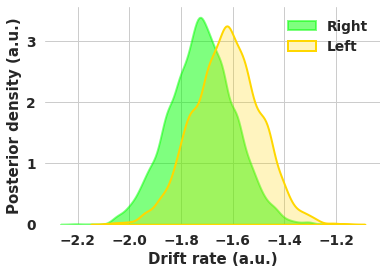

In [78]:
v_Alertright,v_Alertleft = m.nodes_db.node[['v(Alert.Right)','v(Alert.Left)']]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
axplot_1 = sns.kdeplot(v_Alertright.trace(), shade = True,vertical=False, label = "v_Alertright", 
                       color = right_col,linewidth = 2, ax=ax)
axplot_1.collections[0].set_alpha(0.5)
axplot_1 = sns.kdeplot(v_Alertleft.trace(), shade = True, vertical=False, label = "v_Alertleft", 
                       color = left_col,linewidth = 2, ax=ax)
axplot_1.collections[0].set_alpha(0.5)
ax.legend(['Right','Left'],loc='upper right',framealpha = 0)
ax.set(xlabel='Drift rate (a.u.)', ylabel='Posterior density (a.u.)')
effect_size = effectsize(v_Alertleft, v_Alertright)

axplot_1.set_frame_on(False)
axplot_1.grid(True)

print ('P_v(v_Alertleft > v_Alertright) = ', 100*(v_Alertleft.trace() > v_Alertright.trace()).mean())
print ('Effect size = ', effect_size)
plt.savefig(fig_dir + "driftrate_alert.png", bbox_inches = 'tight', pad_inches = 0.1)

P_v(v_Drowsyleft > v_Drowsyright) =  99.85000000000001
Effect size =  4.033721420697058


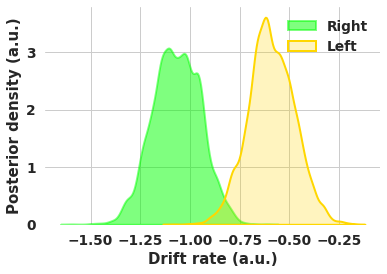

In [79]:
v_Drowsyright,v_Drowsyleft = m.nodes_db.node[['v(Drowsy.Right)','v(Drowsy.Left)']]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
axplot_1 = sns.kdeplot(v_Drowsyright.trace(), shade = True, vertical=False, label = "v_Drowsyright", 
                       color = right_col,linewidth = 2, ax=ax)
axplot_1.collections[0].set_alpha(0.5)
axplot_1 = sns.kdeplot(v_Drowsyleft.trace(), shade = True, vertical=False, label = "v_Drowsyleft", 
                       color = left_col,linewidth = 2, ax=ax)
axplot_1.collections[0].set_alpha(0.5)
ax.legend(['Right','Left'],loc='upper right',framealpha = 0)
ax.set(xlabel='Drift rate (a.u.)', ylabel='Posterior density (a.u.)')
effect_size = effectsize(v_Drowsyleft, v_Drowsyright)

axplot_1.set_frame_on(False)
axplot_1.grid(True)

print ('P_v(v_Drowsyleft > v_Drowsyright) = ', 100*(v_Drowsyleft.trace() > v_Drowsyright.trace()).mean())
print ('Effect size = ', effect_size)
plt.savefig(fig_dir + "driftrate_drowsy.png", bbox_inches = 'tight', pad_inches = 0.1)

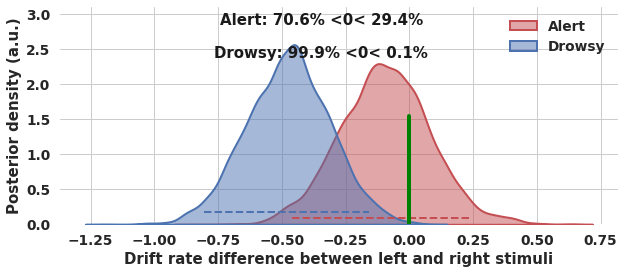

In [80]:
plot_height = 1
ax_labelsize = 12
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))

# alert
trace_alert = v_Alertright.trace() - v_Alertleft.trace()
axplot_1 = sns.kdeplot(trace_alert, shade = True, vertical=False, color=alert_col,
                       linewidth = 2, ax=ax, alpha = 0.5)
# drowsy
trace_drowsy = v_Drowsyright.trace() - v_Drowsyleft.trace()
axplot_1 = sns.kdeplot(trace_drowsy, shade = True, vertical=False, color=drowsy_col,
                       linewidth = 2, ax=ax, alpha = 0.5)


axplot_1.legend(['Alert','Drowsy'],loc='upper right',framealpha = 0)

# alert
less_than_ref_probability = (trace_alert < ref_val).mean()
greater_than_ref_probability = (trace_alert >= ref_val).mean()

ref_in_posterior = "Alert: {} <{:g}< {}".format(format_as_percent(less_than_ref_probability, 1),ref_val,
            format_as_percent(greater_than_ref_probability, 1),)

axplot_1.text(trace_alert.mean()-0.25,4.75 * 0.6,ref_in_posterior,
              color="k", weight="bold",horizontalalignment="center")

hpd_intervals = hdi_of_mcmc(trace_alert)
axplot_1.plot(hpd_intervals,(plot_height * 0.09, plot_height * 0.09),
              lw=1 * 2, color=alert_col, ls = '--', solid_capstyle="round",)

# drowsy
less_than_ref_probability = (trace_drowsy < ref_val).mean()
greater_than_ref_probability = (trace_drowsy >= ref_val).mean()

ref_in_posterior = "Drowsy: {} <{:g}< {}".format(format_as_percent(less_than_ref_probability, 1),ref_val,
            format_as_percent(greater_than_ref_probability, 1),)

axplot_1.text(trace_alert.mean()-0.25,4.75 * 0.5,ref_in_posterior,
              color="k", weight="bold",horizontalalignment="center")

hpd_intervals = hdi_of_mcmc(trace_drowsy)
axplot_1.plot(hpd_intervals,(plot_height * 0.18, plot_height * 0.18),
              lw=1 * 2, color=drowsy_col, ls = '--', solid_capstyle="round",)

axplot_1.axvline(x=0, ymin=0, ymax=0.5, lw=1 * 4, color="green", ls = '-', solid_capstyle="round")

axplot_1.set(xlabel='Drift rate difference between left and right stimuli', ylabel='Posterior density (a.u.)')

axplot_1.set(ylim=(0, 3.1))

axplot_1.set_frame_on(False)
axplot_1.grid(True)
plt.savefig(fig_dir + "driftrate_difference.png", bbox_inches = 'tight', pad_inches = 0.1)

In [81]:
import pymc as pm

In [82]:
# adapted from analyze.py in kabuki package..
def _parents_to_random_posterior_sample_temp(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]

In [83]:
# adapted from analyze.py in kabuki package..
def _plot_posterior_pdf_node_temp(bottom_node, axis, title, rt_col = 'b',
                                  pred_col = 'r',value_range=None, samples=1000, bins=100):
    """Calculate posterior predictive for a certain bottom node.

    :Arguments:
        bottom_node : pymc.stochastic
            Bottom node to compute posterior over.

        axis : matplotlib.axis
            Axis to plot into.

        value_range : numpy.ndarray
            Range over which to evaluate the likelihood.

    :Optional:
        samples : int (default=10)
            Number of posterior samples to use.

        bins : int (default=100)
            Number of bins to compute histogram over.

    """

    if value_range is None:
        # Infer from data by finding the min and max from the nodes
        raise NotImplementedError("value_range keyword argument must be supplied.")

    like = np.empty((samples, len(value_range)), dtype=np.float32)
    for sample in range(samples):
        _parents_to_random_posterior_sample_temp(bottom_node)
        # Generate likelihood for parents parameters
        like[sample,:] = bottom_node.pdf(value_range)

    y = like.mean(axis=0)
    try:
        y_std = like.std(axis=0)
    except FloatingPointError:
        print("WARNING! %s threw FloatingPointError over std computation. Setting to 0 and continuing." 
              % bottom_node.__name__)
        y_std = np.zeros_like(y)

    # Plot pp
    axis.plot(value_range, y, label='post pred', color=pred_col)
    axis.fill_between(value_range, y-y_std, y+y_std, color=pred_col, alpha=.8)

    # Plot data
    if len(bottom_node.value) != 0:
        axis.hist(bottom_node.value.values, density=True, color=rt_col,
                  range=(value_range[0], value_range[-1]), label='data',
                  bins=bins, histtype='step', lw=2.)

    axis.set_ylim(0,3.2) # Likelihood and histogram can only be positive
    axis.set(xlabel='RT (sec)', ylabel='Frequencies')
    axis.set_title(title,fontsize=label_fontsize, weight = 'bold')
    
    sns.despine(left=True, bottom = True)
    axis.grid(True)

In [84]:
print('drift rate depends on: ', ', '.join(m.nodes_db.depends['v(Alert.Right)']))
print('bias depends on:', ', '.join(m.nodes_db.depends['z(Right)']))
print('boundary depends on:', ', '.join(m.nodes_db.depends['a(Alert)']))
print('non-decision time depends on:', ', '.join(m.nodes_db.depends['t(Alert)']))

drift rate depends on:  state, stim
bias depends on: stim
boundary depends on: state
non-decision time depends on: state


In [85]:
observeds = m.get_observeds()

In [86]:
for tag, nodes in observeds.groupby('tag'):
    print(tag)

('Alert', 'Left')
('Alert', 'Right')
('Drowsy', 'Left')
('Drowsy', 'Right')


In [87]:
kwargs = dict()
kwargs['value_range'] = np.linspace(-3, 3, 100)

In [88]:
pal = {Condition: "b" if Condition == 'Drowsy' else "r" for Condition in ['Alert', 'Drowsy']}

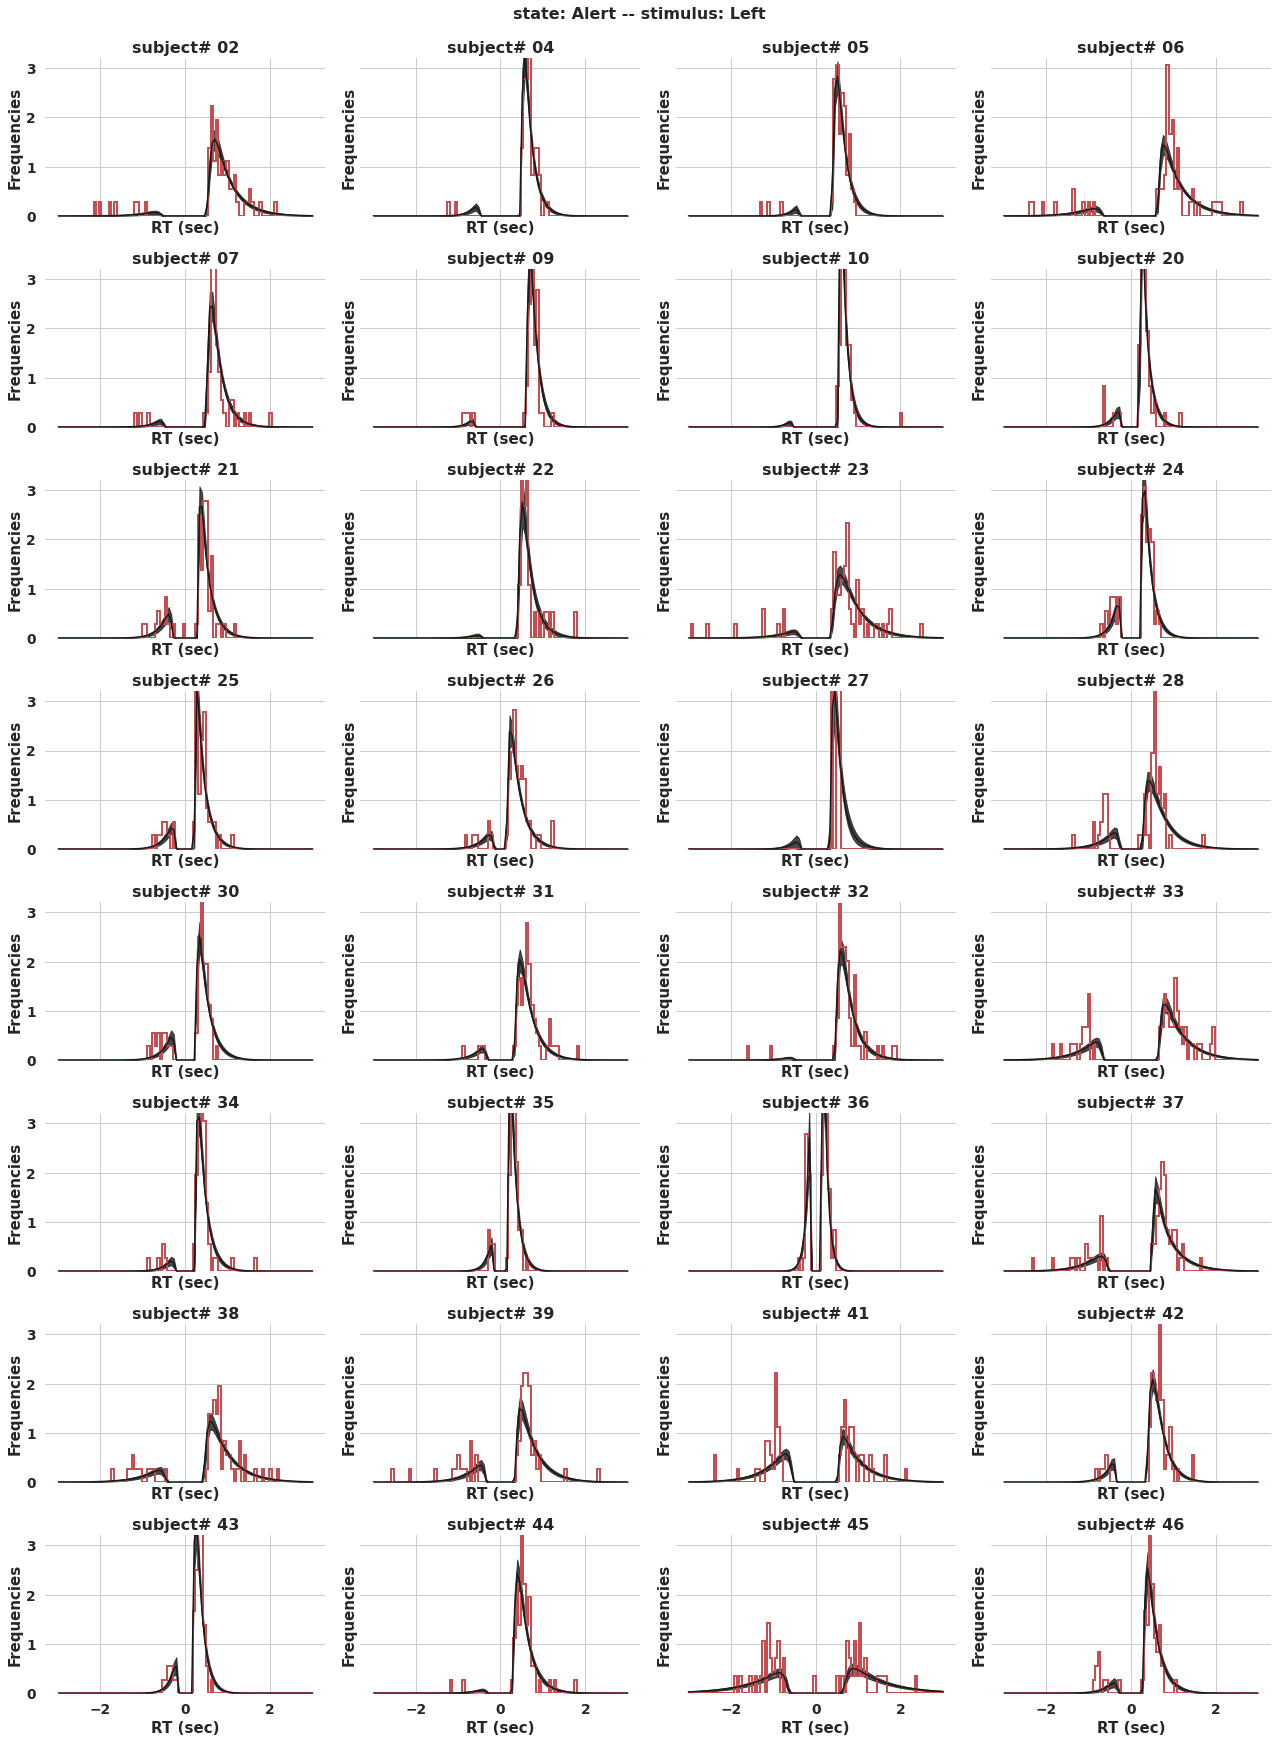

In [89]:
for tag, nodes in observeds.groupby('tag'):
    cond_str = 'state: ' + tag[0] + ' -- stimulus: ' + tag[1]
    if cond_str == 'state: Alert -- stimulus: Left':
        #print cond_str
        tPlot, axes = plt.subplots(figsize=(18, 24),
            nrows=8, ncols=4, sharex=True, sharey=True)
        for s, (node_name, bottom_node) in enumerate(nodes.iterrows()):  # Loop across each subject
            rowidx = s//4
            colidx = s%4
            display_str = "%02d" % (int(bottom_node['subj_idx']),)
            titlestr = 'subject#' + ' ' + display_str

            _plot_posterior_pdf_node_temp(bottom_node['node'], axes[rowidx,colidx],titlestr, pred_col = 'k',
                                          rt_col = pal[tag[0]],**kwargs)
        
        
        plt.tight_layout()
        suptitle = plt.suptitle(cond_str, y = 1.01, fontsize=label_fontsize, weight = 'bold')
        plt.box(False)
        plt.grid(True)
        plt.savefig(fig_dir + "suppl_hddm_postpred_" + tag[0] + '_' + tag[1] + ".png",
                    bbox_inches='tight', bbox_extra_artists=[suptitle],
                    format='png', dpi=240, transparent=False)  

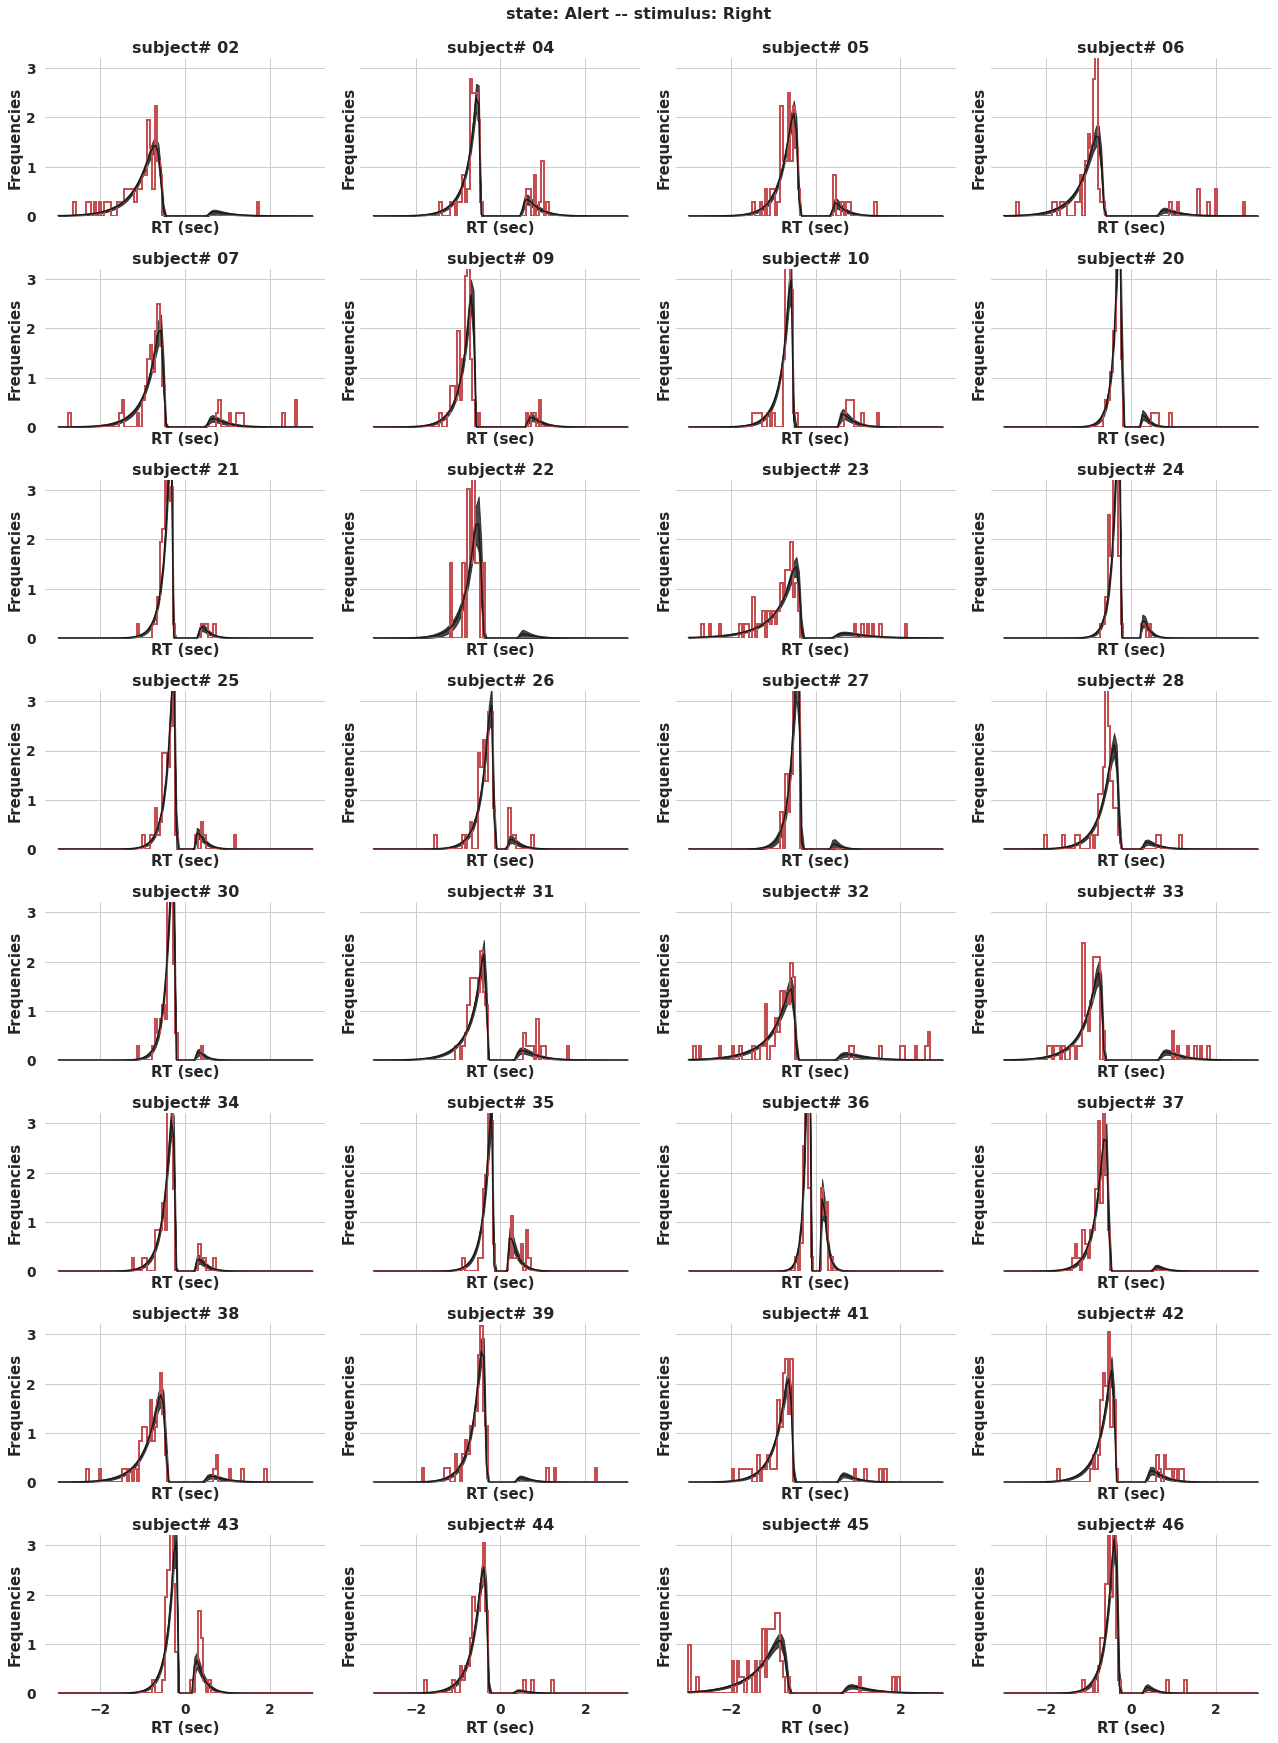

In [90]:
for tag, nodes in observeds.groupby('tag'):
    cond_str = 'state: ' + tag[0] + ' -- stimulus: ' + tag[1]
    if cond_str == 'state: Alert -- stimulus: Right':
        #print cond_str
        tPlot, axes = plt.subplots(figsize=(18, 24),
            nrows=8, ncols=4, sharex=True, sharey=True)
        for s, (node_name, bottom_node) in enumerate(nodes.iterrows()):  # Loop across each subject
            rowidx = s//4
            colidx = s%4
            display_str = "%02d" % (int(bottom_node['subj_idx']),)
            titlestr = 'subject#' + ' ' + display_str

            _plot_posterior_pdf_node_temp(bottom_node['node'], axes[rowidx,colidx],titlestr, pred_col = 'k',
                                          rt_col = pal[tag[0]],**kwargs)
        
        
        plt.tight_layout()
        suptitle = plt.suptitle(cond_str, y = 1.01, fontsize=label_fontsize, weight = 'bold')
        plt.box(False)
        plt.grid(True)
        plt.savefig(fig_dir + "suppl_hddm_postpred_" + tag[0] + '_' + tag[1] + ".png",
                    bbox_inches='tight', bbox_extra_artists=[suptitle],
                    format='png', dpi=240, transparent=False) 

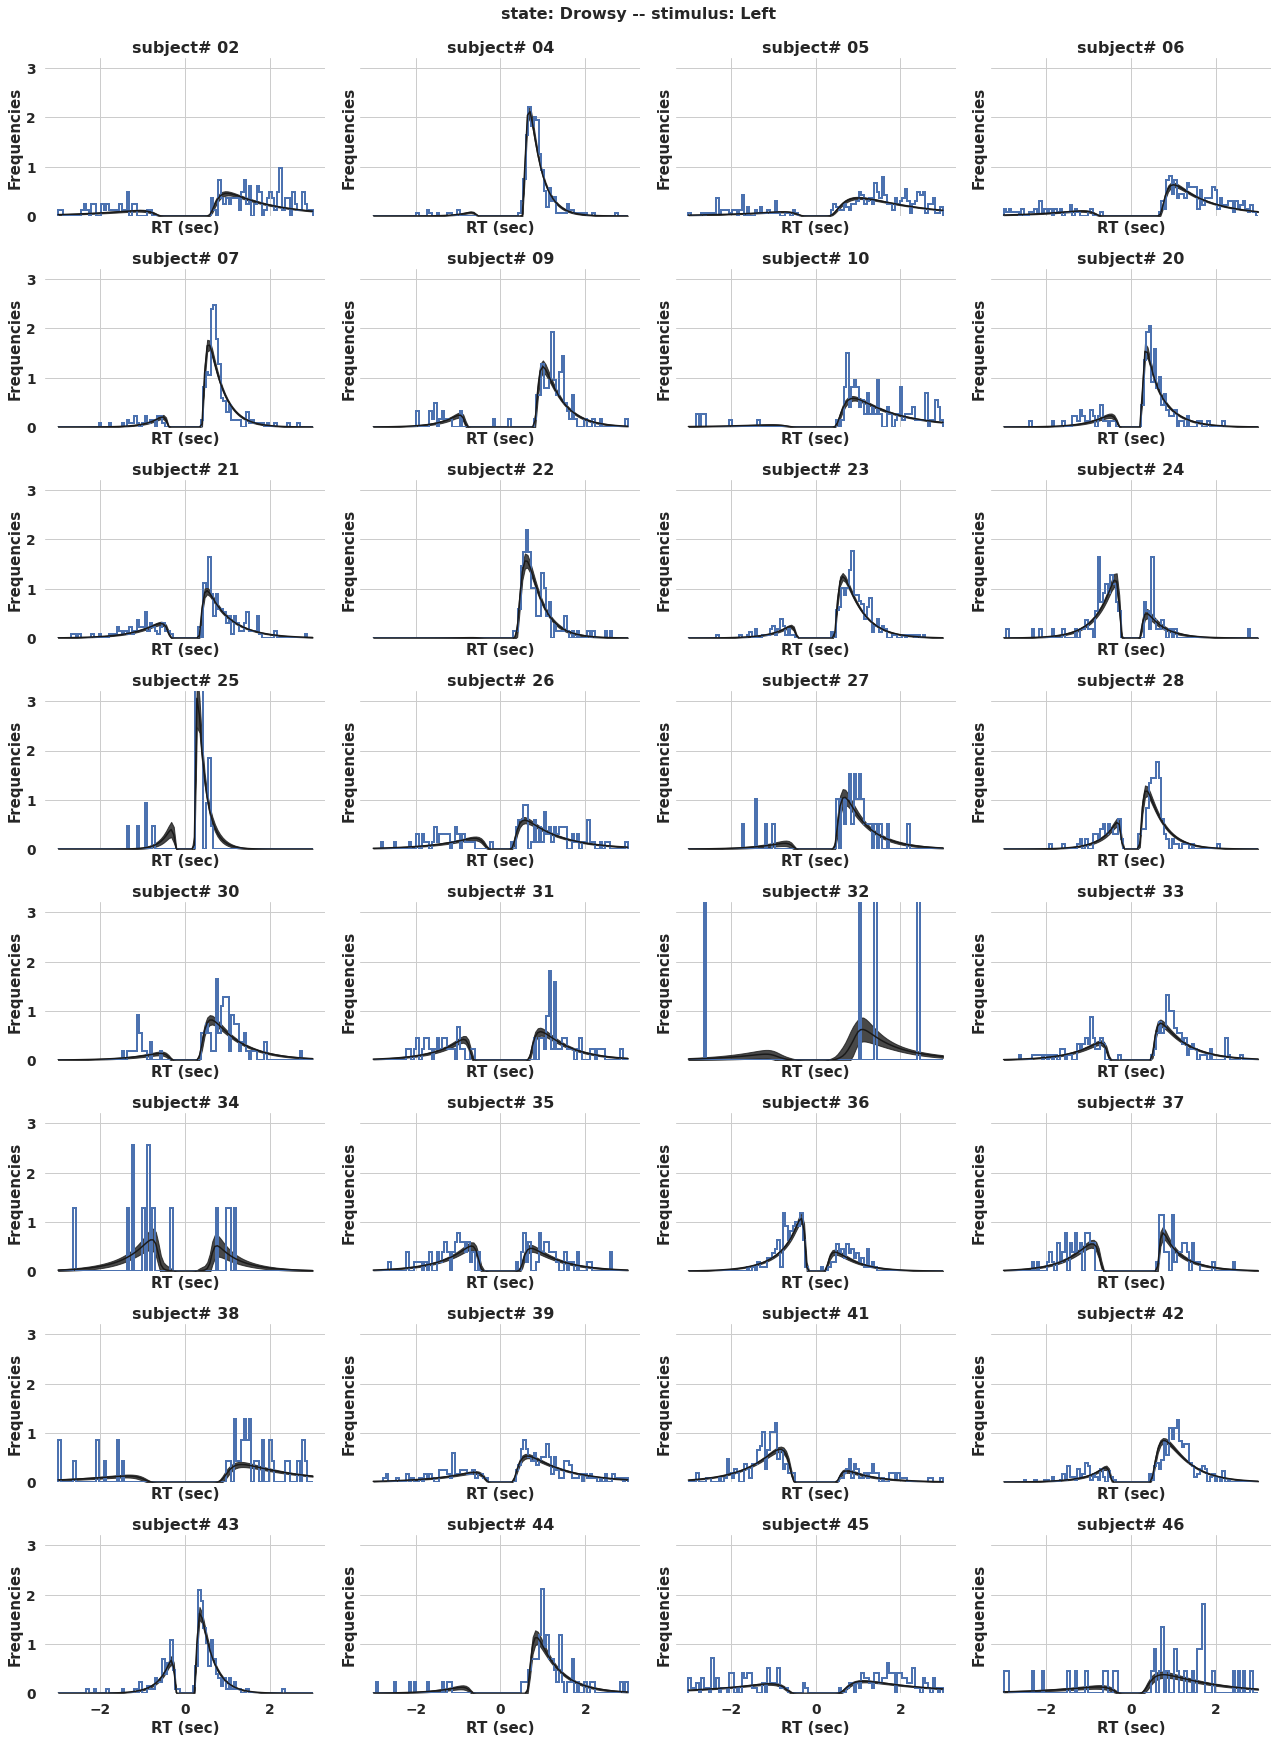

In [91]:
for tag, nodes in observeds.groupby('tag'):
    cond_str = 'state: ' + tag[0] + ' -- stimulus: ' + tag[1]
    if cond_str == 'state: Drowsy -- stimulus: Left':
        #print cond_str
        tPlot, axes = plt.subplots(figsize=(18, 24),
            nrows=8, ncols=4, sharex=True, sharey=True)
        for s, (node_name, bottom_node) in enumerate(nodes.iterrows()):  # Loop across each subject
            rowidx = s//4
            colidx = s%4
            display_str = "%02d" % (int(bottom_node['subj_idx']),)
            titlestr = 'subject#' + ' ' + display_str

            _plot_posterior_pdf_node_temp(bottom_node['node'], axes[rowidx,colidx],titlestr, pred_col = 'k',
                                          rt_col = pal[tag[0]],**kwargs)
        
        
        plt.tight_layout()
        suptitle = plt.suptitle(cond_str, y = 1.01, fontsize=label_fontsize, weight = 'bold')
        plt.box(False)
        plt.grid(True)
        plt.savefig(fig_dir + "suppl_hddm_postpred_" + tag[0] + '_' + tag[1] + ".png",
                    bbox_inches='tight', bbox_extra_artists=[suptitle],
                    format='png', dpi=240, transparent=False) 

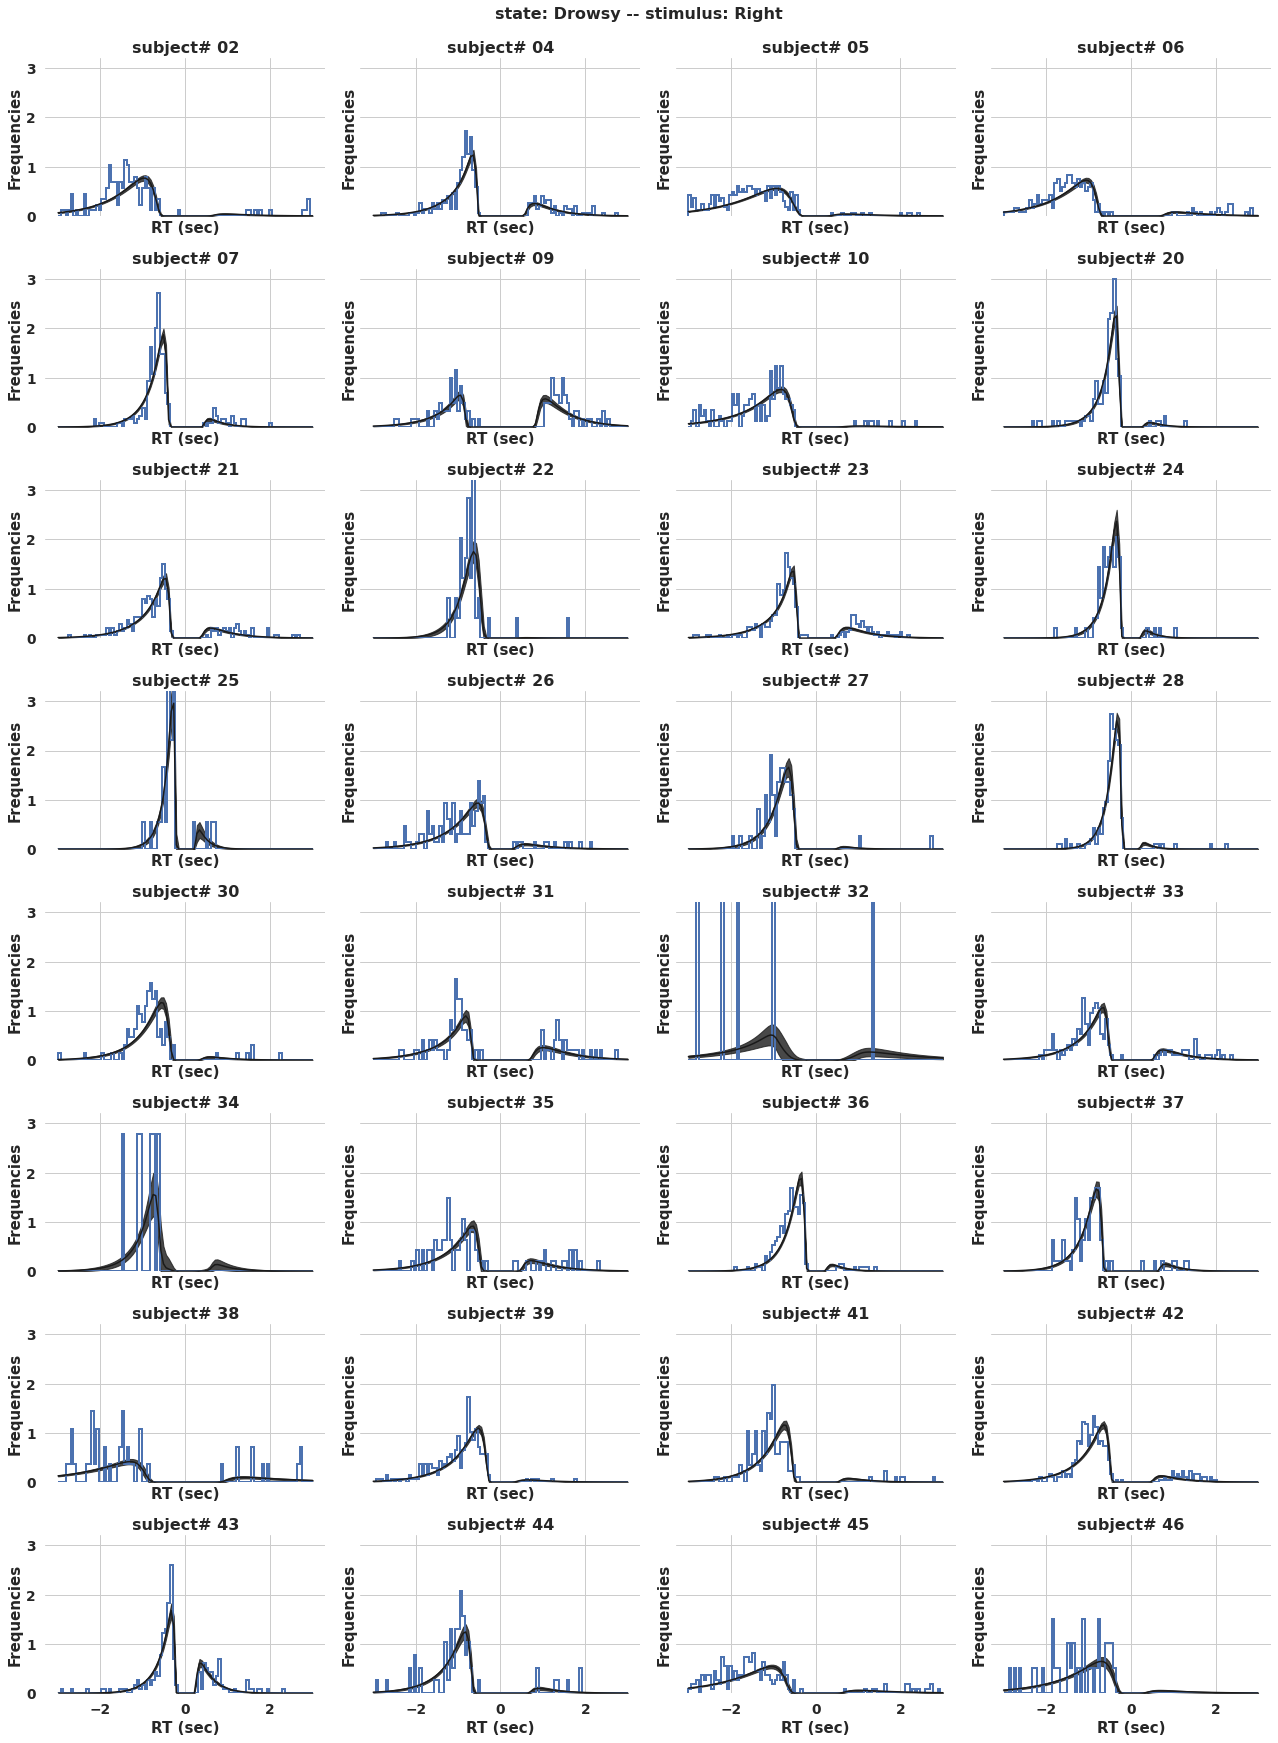

In [92]:
for tag, nodes in observeds.groupby('tag'):
    cond_str = 'state: ' + tag[0] + ' -- stimulus: ' + tag[1]
    if cond_str == 'state: Drowsy -- stimulus: Right':
        #print cond_str
        tPlot, axes = plt.subplots(figsize=(18, 24),
            nrows=8, ncols=4, sharex=True, sharey=True)
        for s, (node_name, bottom_node) in enumerate(nodes.iterrows()):  # Loop across each subject
            rowidx = s//4
            colidx = s%4
            display_str = "%02d" % (int(bottom_node['subj_idx']),)
            titlestr = 'subject#' + ' ' + display_str

            _plot_posterior_pdf_node_temp(bottom_node['node'], axes[rowidx,colidx],titlestr, pred_col = 'k',
                                          rt_col = pal[tag[0]],**kwargs)
        
        
        plt.tight_layout()
        suptitle = plt.suptitle(cond_str, y = 1.01, fontsize=label_fontsize, weight = 'bold')
        plt.box(False)
        plt.grid(True)
        plt.savefig(fig_dir + "suppl_hddm_postpred_" + tag[0] + '_' + tag[1] + ".png",
                    bbox_inches='tight', bbox_extra_artists=[suptitle],
                    format='png', dpi=240, transparent=False) 